# P06 · Velocimetría de Partículas por Imagen (PIV)

Esta libreta guía todo el flujo de trabajo de la práctica P06: desde la carga de pares de imágenes sintéticas PIV hasta el cálculo del flujo óptico (Farnebäck), magnitud de velocidad, vorticidad y visualizaciones (vectores, mapas y líneas de corriente).

- Origen de datos: `../../../files/p6` (desde esta libreta).
- Salida de figuras: `../data/images` en formatos PNG y SVG.
- Interactividad con `ipywidgets` para elegir pares y ajustar parámetros.

Sugerencia: lee primero el archivo `../p6.md` para el contexto teórico y las actividades esperadas.

In [1]:
# Imports y configuración base
from pathlib import Path
import re
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

# Activar backend interactivo si está disponible (ipympl)
try:
    from IPython import get_ipython
    get_ipython().run_line_magic('matplotlib', 'widget')
except Exception:
    # En VS Code generalmente funciona inline por defecto
    pass

# Rutas principales
NB_DIR = Path.cwd().resolve()
IMAGES_DIR = NB_DIR.parents[2] / 'files' / 'p6'  # ../../../files/p6
OUTPUT_DIR = NB_DIR.parent / 'data' / 'images'   # ../data/images
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Directorio de trabajo:', NB_DIR)
print('Directorio de imágenes:', IMAGES_DIR)
print('Directorio de salida:', OUTPUT_DIR)

# Utils para guardar figuras en PNG y SVG
def save_figure(fig: matplotlib.figure.Figure, base_name: str, dpi: int = 150):
    png_path = OUTPUT_DIR / f'{base_name}.png'
    svg_path = OUTPUT_DIR / f'{base_name}.svg'
    fig.savefig(png_path, dpi=dpi, bbox_inches='tight')
    fig.savefig(svg_path, dpi=dpi, bbox_inches='tight')
    return png_path, svg_path

# Estado global sencillo para el último resultado y figuras generadas
LAST_RESULT = {}  # {'u':..., 'v':..., 'magnitude':..., 'vorticity':..., 'img1':..., 'img2':...}
LAST_FIGS = []   # lista de matplotlib.figure.Figure

Directorio de trabajo: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\notebooks
Directorio de imágenes: C:\Users\edgar\Documents\GitHub\Aero-Messure\files\p6
Directorio de salida: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P06_PIV\data\images


In [2]:
# Funciones de ayuda: descubrimiento de imágenes, carga, cálculo y gráficos

IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

def list_images(images_dir: Path):
    if not images_dir.exists():
        return []
    files = sorted([p for p in images_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
    return files

def infer_pairs(files):
    # Heurística para emparejar nombres que comparten prefijo y terminan en ..._0 / ..._1
    from collections import defaultdict
    groups = defaultdict(list)
    for f in files:
        stem = f.stem.lower()
        key = None
        if len(stem) >= 1 and stem[-1] in '01':
            key = stem[:-1]
        else:
            m = re.match(r'(.+?)[_-](\d+)$', stem)
            if m:
                key = m.group(1)
        if key:
            groups[key].append(f)
    pairs = []
    for key, items in groups.items():
        # Buscar específicamente sufijos 0 y 1
        m0 = [p for p in items if p.stem.lower().endswith('0')]
        m1 = [p for p in items if p.stem.lower().endswith('1')]
        if m0 and m1:
            pairs.append((sorted(m0)[0], sorted(m1)[0]))
    return sorted(pairs, key=lambda ab: (ab[0].name, ab[1].name))

def load_gray_pair(p1: Path, p2: Path):
    img1 = cv2.imread(str(p1), cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(str(p2), cv2.IMREAD_GRAYSCALE)
    if img1 is None or img2 is None:
        raise FileNotFoundError('No se pudieron cargar las imágenes seleccionadas.')
    if img1.shape != img2.shape:
        raise ValueError('Las imágenes deben tener el mismo tamaño.')
    return img1, img2

def compute_optical_flow(img1, img2, pyr_scale=0.5, levels=3, winsize=15, iterations=3, poly_n=5, poly_sigma=1.2):
    flow = cv2.calcOpticalFlowFarneback(
        prev=img1, next=img2, flow=None,
        pyr_scale=pyr_scale, levels=int(levels), winsize=int(winsize), iterations=int(iterations),
        poly_n=int(poly_n), poly_sigma=float(poly_sigma), flags=0
    )
    u = flow[..., 0]
    v = flow[..., 1]
    magnitude = np.sqrt(u**2 + v**2)
    dv_dy, dv_dx = np.gradient(v)
    du_dy, du_dx = np.gradient(u)
    vorticity = dv_dx - du_dy
    return u, v, magnitude, vorticity

def plot_quiver(img, u, v, step=20, scale=0.2, color='lime'):
    h, w = img.shape[:2]
    # Calculate grid points for arrows (same as before)
    y, x = np.mgrid[step//2:h:step, step//2:w:step]

    # Sample u and v AT the grid points x, y
    # Ensure indices are integers if needed, though advanced indexing often handles floats
    # Note: Numpy indexing is [row, column], which corresponds to [y, x] here
    try:
        u_s = u[y.astype(int), x.astype(int)]
        v_s = v[y.astype(int), x.astype(int)]
    except IndexError:
         # Fallback or alternative indexing if direct float indexing fails or causes issues
         # This might happen if y or x calculated by mgrid go slightly out of bounds
         # A safer way, maybe slightly slower:
         y_idx = np.clip(y.astype(int), 0, h - 1)
         x_idx = np.clip(x.astype(int), 0, w - 1)
         u_s = u[y_idx, x_idx]
         v_s = v[y_idx, x_idx]

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.imshow(img, cmap='gray', alpha=0.7)
    # Now x, y, u_s, v_s should have the same shape
    ax.quiver(x, y, u_s, v_s, color=color, scale_units='xy', angles='xy', scale=scale, headwidth=3, headlength=5, width=0.003)
    ax.set_title('Campo de Velocidad (quiver)')
    ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
    ax.invert_yaxis()
    fig.tight_layout()
    return fig

def plot_magnitude(magnitude, cmap='viridis'):
    fig, ax = plt.subplots(figsize=(9, 7))
    im = ax.imshow(magnitude, cmap=cmap)
    cbar = fig.colorbar(im, ax=ax, label='|V| [px/Δt]')
    ax.set_title('Magnitud de la Velocidad')
    ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
    ax.invert_yaxis()
    fig.tight_layout()
    return fig

def plot_vorticity(vorticity, cmap='bwr'):
    vmax = np.max(np.abs(vorticity)) or 1.0
    fig, ax = plt.subplots(figsize=(9, 7))
    im = ax.imshow(vorticity, cmap=cmap, vmin=-vmax, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax, label='ωz [1/Δt]')
    ax.set_title('Vorticidad')
    ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
    ax.invert_yaxis()
    fig.tight_layout()
    return fig

def plot_streamlines(u, v, background=None, density=1.2, color='cyan'):
    h, w = u.shape
    Y, X = np.mgrid[0:h, 0:w]
    fig, ax = plt.subplots(figsize=(9, 7))
    if background is not None:
        ax.imshow(background, cmap='gray', alpha=0.5)
    strm = ax.streamplot(X, Y, u, v, color=color, linewidth=1, density=density, arrowsize=1.5)
    ax.set_title('Líneas de Corriente')
    ax.set_xlabel('X [px]'); ax.set_ylabel('Y [px]')
    ax.set_xlim(0, w); ax.set_ylim(0, h)
    ax.invert_yaxis()
    fig.tight_layout()
    return fig

In [3]:
# Descubrir archivos y construir lista de pares sugeridos
all_imgs = list_images(IMAGES_DIR)
pairs = infer_pairs(all_imgs)
print(f'Se encontraron {len(all_imgs)} imágenes y {len(pairs)} pares sugeridos.')
for a,b in pairs[:10]:
    print(' -', a.name, '<->', b.name)

Se encontraron 4 imágenes y 1 pares sugeridos.
 - rankine_vortex03_0.tif <-> rankine_vortex03_1.tif


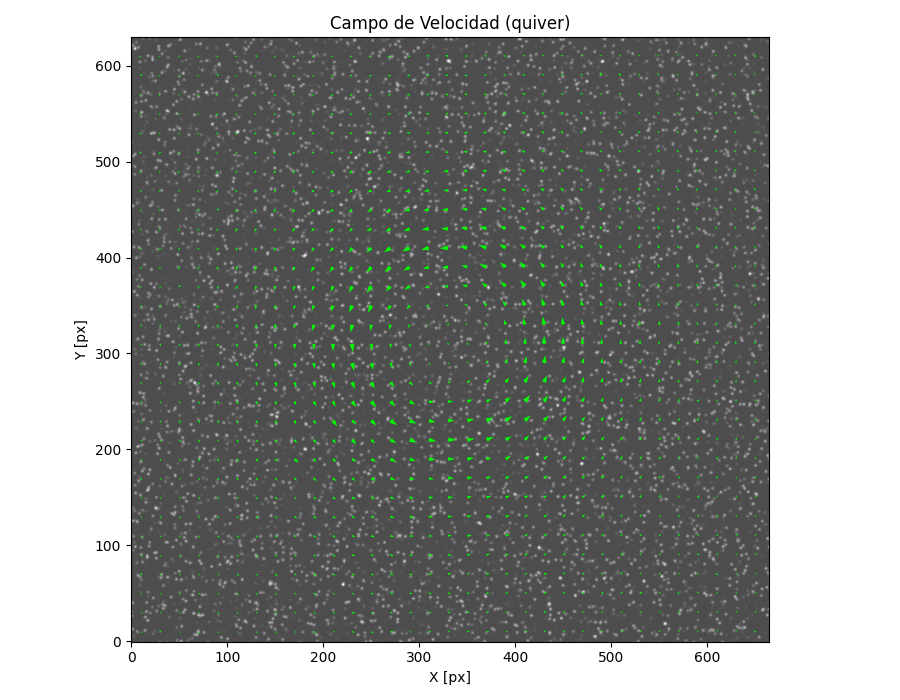

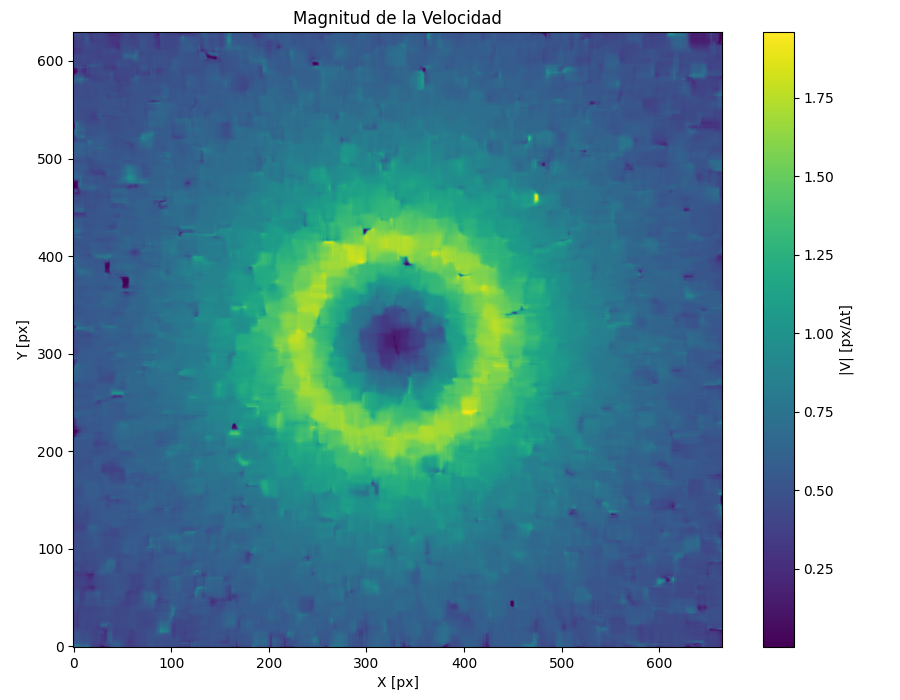

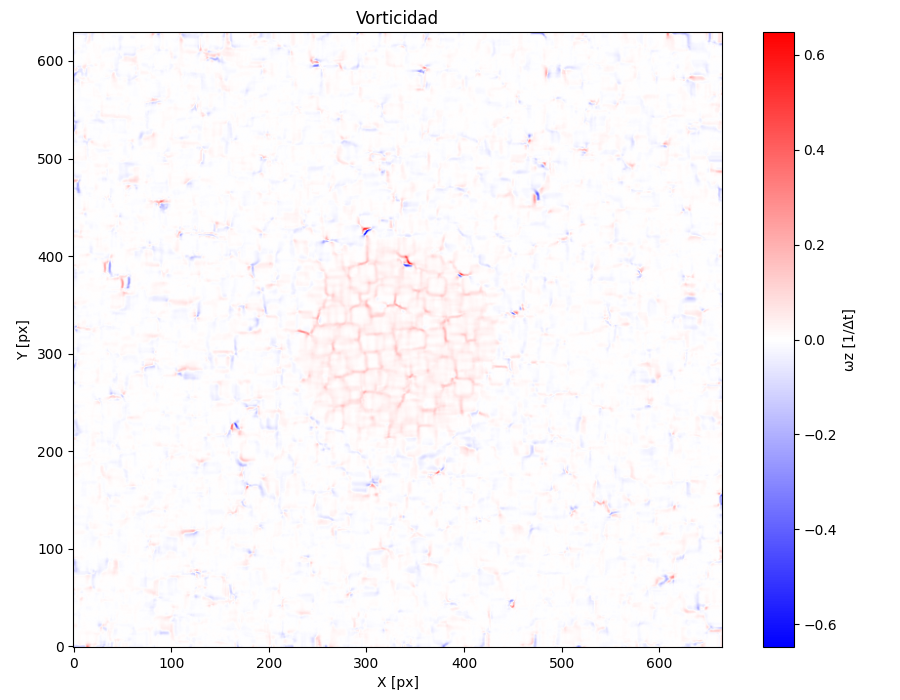

In [4]:
# Widgets de interacción y proceso principal

# Selección de par (si existen) y alternativa manual
pair_options = [(f'{a.name}  |  {b.name}', (a, b)) for (a, b) in pairs]
img_options = [p.name for p in all_imgs]

use_inferred = widgets.ToggleButtons(options=['Par inferido', 'Selección manual'], value='Par inferido', description='Modo:')
pair_dd = widgets.Dropdown(options=pair_options if pair_options else [('—', (None, None))], description='Par:')
img1_dd = widgets.Dropdown(options=img_options, description='Imagen 1:')
img2_dd = widgets.Dropdown(options=img_options, description='Imagen 2:')

# Parámetros de Farnebäck
pyr_scale_w = widgets.FloatSlider(value=0.5, min=0.3, max=0.9, step=0.05, description='pyr_scale')
levels_w = widgets.IntSlider(value=3, min=1, max=6, step=1, description='levels')
winsize_w = widgets.IntSlider(value=15, min=5, max=45, step=2, description='winsize')
iterations_w = widgets.IntSlider(value=3, min=1, max=10, step=1, description='iterations')
poly_n_w = widgets.SelectionSlider(options=[5, 7], value=5, description='poly_n')
poly_sigma_w = widgets.FloatSlider(value=1.2, min=0.8, max=2.0, step=0.1, description='poly_sigma')

# Parámetros de visualización
step_w = widgets.IntSlider(value=20, min=5, max=40, step=1, description='step quiver')
scale_w = widgets.FloatSlider(value=0.2, min=0.05, max=2.0, step=0.05, description='scale quiver')
cmap_mag_w = widgets.Dropdown(options=['viridis', 'plasma', 'inferno', 'magma'], value='viridis', description='cmap |V|')
cmap_vort_w = widgets.Dropdown(options=['bwr', 'seismic', 'PiYG'], value='bwr', description='cmap ωz')
stream_toggle = widgets.Checkbox(value=False, description='Dibujar streamlines')
stream_density = widgets.FloatSlider(value=1.2, min=0.5, max=2.5, step=0.1, description='densidad')

# Botones y nombre base para guardar
run_btn = widgets.Button(description='Procesar', button_style='primary')
save_btn = widgets.Button(description='Guardar figuras (PNG+SVG)', button_style='success')
basename_txt = widgets.Text(value='p06_piv', description='Base nombre:')
status_out = widgets.Output()
plots_out = widgets.Output()

def current_selection():
    if use_inferred.value == 'Par inferido' and pair_options:
        a, b = pair_dd.value
    else:
        if not all_imgs:
            return None, None
        a = IMAGES_DIR / img1_dd.value
        b = IMAGES_DIR / img2_dd.value
    return a, b

def on_run_clicked(_):
    global LAST_RESULT, LAST_FIGS
    a, b = current_selection()
    with status_out:
        clear_output(wait=True)
        try:
            img1, img2 = load_gray_pair(a, b)
        except Exception as e:
            print('Error de selección/carga:', e)
            return
        # Cálculo de flujo óptico
        u, v, mag, vort = compute_optical_flow(
            img1, img2,
            pyr_scale=pyr_scale_w.value, levels=levels_w.value, winsize=winsize_w.value,
            iterations=iterations_w.value, poly_n=poly_n_w.value, poly_sigma=poly_sigma_w.value
)
        LAST_RESULT = {
            'u': u, 'v': v, 'magnitude': mag, 'vorticity': vort, 'img1': img1, 'img2': img2,
            'files': (str(a.name) if a else '', str(b.name) if b else '')
        }
        print('Flujo óptico calculado:', u.shape)
    # Dibujos
    LAST_FIGS = []
    with plots_out:
        clear_output(wait=True)
        f1 = plot_quiver(LAST_RESULT['img1'], LAST_RESULT['u'], LAST_RESULT['v'], step=step_w.value, scale=scale_w.value)
        f2 = plot_magnitude(LAST_RESULT['magnitude'], cmap=cmap_mag_w.value)
        f3 = plot_vorticity(LAST_RESULT['vorticity'], cmap=cmap_vort_w.value)
        display(f1); display(f2); display(f3)
        LAST_FIGS.extend([f1, f2, f3])
        if stream_toggle.value:
            f4 = plot_streamlines(LAST_RESULT['u'], LAST_RESULT['v'], background=LAST_RESULT['img1'], density=stream_density.value)
            display(f4)
            LAST_FIGS.append(f4)

def on_save_clicked(_):
    base = basename_txt.value.strip() or 'p06_piv'
    if not LAST_FIGS:
        with status_out:
            clear_output(wait=True)
            print('No hay figuras para guardar. Ejecuta primero Procesar.')
        return
    saved = []
    tag = ''
    if 'files' in LAST_RESULT:
        fa, fb = LAST_RESULT['files']
        tag = f"_{fa.replace('.', '-')}_{fb.replace('.', '-')}_{levels_w.value}-{winsize_w.value}-{iterations_w.value}-{poly_n_w.value}"
    for i, fig in enumerate(LAST_FIGS, start=1):
        name = f"{base}_fig{i}{tag}"
        png_path, svg_path = save_figure(fig, name)
        saved.append((png_path, svg_path))
    with status_out:
        clear_output(wait=True)
        print('Guardado en:')
        for p, s in saved:
            print(' -', p.name, 'y', s.name)

run_btn.on_click(on_run_clicked)
save_btn.on_click(on_save_clicked)

# Layout
row_mode = widgets.HBox([use_inferred])
row_pair = widgets.HBox([pair_dd])
row_manual = widgets.HBox([img1_dd, img2_dd])
box_params1 = widgets.HBox([pyr_scale_w, levels_w, winsize_w])
box_params2 = widgets.HBox([iterations_w, poly_n_w, poly_sigma_w])
box_viz = widgets.HBox([step_w, scale_w, cmap_mag_w, cmap_vort_w])
box_stream = widgets.HBox([stream_toggle, stream_density])
box_actions = widgets.HBox([run_btn, save_btn, basename_txt])

def _toggle_visibility(*args):
    row_pair.layout.display = 'flex' if (use_inferred.value == 'Par inferido') else 'none'
    row_manual.layout.display = 'none' if (use_inferred.value == 'Par inferido') else 'flex'

use_inferred.observe(_toggle_visibility, 'value')
_toggle_visibility()

ui = widgets.VBox([
    widgets.HTML('<h3>Selección de imágenes y parámetros</h3>'),
    row_mode, row_pair, row_manual,
    widgets.HTML('<h4>Parámetros de Farnebäck</h4>'),
    box_params1, box_params2,
    widgets.HTML('<h4>Visualización</h4>'),
    box_viz, box_stream,
    box_actions,
    status_out,
    widgets.HTML('<hr>'),
    plots_out
])
display(ui)

## Uso
1. Verifica que `../../../files/p6` contiene los pares (por ejemplo `rankine_vortex03_0.jpg` y `rankine_vortex03_1.jpg`).
2. Elige el modo: par inferido (si fue detectado) o selección manual.
3. Ajusta los parámetros de Farnebäck y los de visualización.
4. Pulsa ‘Procesar’ para calcular y mostrar: quiver, |V| y ωz (y opcionalmente streamlines).
5. Pulsa ‘Guardar figuras’ para exportar PNG y SVG en `../data/images`.

In [ ]:
from datetime import datetime

def generar_reporte_md(base_name: str):
    ts = datetime.now().strftime('%Y-%m-%d %H:%M')
    fa, fb = LAST_RESULT.get('files', ('', ''))
    lines = [
        f"# Reporte P06 — {ts}",
        '',
        f"Par: {fa} | {fb}",
        f"Parámetros Farnebäck: pyr_scale={pyr_scale_w.value}, levels={levels_w.value}, winsize={winsize_w.value}, "+
        f"iterations={iterations_w.value}, poly_n={poly_n_w.value}, poly_sigma={poly_sigma_w.value}",
        f"Visualización: step={step_w.value}, scale={scale_w.value}, cmap|V|={cmap_mag_w.value}, cmapωz={cmap_vort_w.value}, stream={stream_toggle.value}",
        '',
        'Figuras exportadas:',
    ]
    for i in range(1, len(LAST_FIGS)+1):
        tag = f"_{fa.replace('.', '-')}_{fb.replace('.', '-')}_{levels_w.value}-{winsize_w.value}-{iterations_w.value}-{poly_n_w.value}"
        lines.append(f"- {base_name}_fig{i}{tag}.png")
        lines.append(f"- {base_name}_fig{i}{tag}.svg")
    md = '\n'.join(lines)
    out_md = OUTPUT_DIR / f'{base_name}_reporte.md'
    out_md.write_text(md, encoding='utf-8')
    print('Reporte generado en', out_md)

# Ejemplo de uso: una vez guardadas las figuras, corre: generar_reporte_md(basename_txt.value)

## Guía para el análisis (edita este bloque con tus respuestas)
- Describe las principales características del flujo observadas (vórtices, zonas de cizalladura, estelas).
- Identifica regiones de alta y baja velocidad a partir de |V|.
- Localiza regiones de alta vorticidad (positiva/negativa) y comenta si corresponden a estructuras esperadas (p.ej., vórtice de Rankine).
- Discute relevancia en contexto aeronáutico (perfil alar, flap, fuselaje) y limitaciones del flujo óptico vs PIV clásico.
- Documenta parámetros utilizados y justifica elecciones (Δt implícito, tam. ventana, etc.).